In [1]:
import time
import pickle
import calendar
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [6]:
class preprocess():
    # Class attributes - universal across all objects
    with open ("trained model/sc_energy.pkl", "rb") as file:
        sc_energy = pickle.load(file)
    with open ("trained model/sc_price.pkl", "rb") as file:
        sc_price = pickle.load(file)    
    
    def __init__(self):
        with open("trained model/feature.pkl", "rb") as file:
            self.features = pickle.load(file)
            
    def feature_engineering(self, df):
        # Find last Monday for holiday
        def last_mon_date(year, month):
            """
            Returns a matrix representing a month’s calendar
            Each row represents a week; days outside of the month a represented by zeros
            Each week begins with Monday
            """
            cal = calendar.monthcalendar(year, month)
            last_mon_date = cal[4][0] if (cal[4][0] > 0) else cal[3][0]
            return str(year)+"-"+str(month)+"-"+str(last_mon_date)

        df["time"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%m%d%Y %H:%M")) # Convert to timestamp from string 
        #df = df.set_index(["time"])

        df["Year"] = df["time"].apply(lambda x: x.year)
        df["Month"] = df["time"].apply(lambda x: x.month)
        df["Day"] = df["time"].apply(lambda x: x.day)
        df["Weekday"] = df["time"].apply(lambda x: x.weekday() + 1) # To adjust to 1 to 7 instead of 0 to 6
        df["Week"] = df["Day"].apply(lambda x: (x-1)//7+1)
        df["Weekend"] = df["Weekday"].apply(lambda x: 1 if x>=6 else 0) # Apply function to the column (default: axis=0)
        df["Hour"] = df["time"].apply(lambda x: x.hour)

        # Find last Monday in May
        unique_year = df["Year"].unique()
        last_mon_may = []
        for i in range(0, unique_year.shape[0], 1):
            last_mon_may.append(last_mon_date(unique_year[i], 5))
        last_mon_may = [time.mktime(datetime.datetime.strptime(x,"%Y-%m-%d").timetuple()) for x in last_mon_may] # Convert to timestamp

        df["Holiday"] = 0
        df["Holiday"] = df["time"].apply(lambda x: 1 if (datetime.datetime.timestamp(x) in last_mon_may) else 0)
        df["Holiday"].loc[(df["Month"] == 1) & (df["Day"] == 1)] = 1 # Remember () for condition
        df["Holiday"].loc[(df["Month"] == 12) & (df["Day"] == 25)] = 1
        df["Holiday"].loc[(df["Month"] == 11) & (df["Day"] == 11)] = 1
        df["Holiday"].loc[(df["Month"] == 7) & (df["Day"] == 4)] = 1
        df["Holiday"].loc[(df["Month"] == 1) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1
        df["Holiday"].loc[(df["Month"] == 2) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1 
        df["Holiday"].loc[(df["Month"] == 11) & (df["Week"] == 4) & (df["Weekday"] == 4)] = 1
        df["Holiday"].loc[(df["Month"] == 10) & (df["Week"] == 2) & (df["Weekday"] == 1)] = 1
        df["Holiday"].loc[(df["Month"] == 9) & (df["Week"] == 1) & (df["Weekday"] == 1)] = 1  

        df_sub = pd.get_dummies(df["Month"], drop_first=False, prefix="Month_")
        df_sub2 = pd.get_dummies(df["Weekday"], drop_first=False, prefix="Weekday_")
        df_sub3 = pd.get_dummies(df["Hour"], drop_first=False, prefix="Hour_")
        df = pd.concat([df, df_sub, df_sub2, df_sub3], axis=1)
        df = df.drop(["timestamp"], axis=1)

        # Create important attributes/ selected features if it is missing from the current dataset
        # Assign value to be zeros
        for feature in self.features:
            if feature not in df.columns.tolist():
                df[feature] = 0

        # Remove the unwanted features and sort it according to the training set sequence
        for column in df.columns:
            if column not in self.features:
                df.drop(column, axis=1, inplace=True)

        df = df[self.features]

        return df
    
    @staticmethod
    # Not involve any class or object properties or methods
    def get_sequential_data(timesteps_in, timesteps_out, serial_data, feature_data):
        
        x, x2, y, y2 = [], [], [], []
        for i in range (timesteps_in, len(serial_data)-timesteps_out+1, 1):
            x.append(serial_data[i-timesteps_in:i])
            x2.append(feature_data[i-timesteps_in:i])
            y.append(serial_data[i:i+timesteps_out])
            y2.append(feature_data[i:i+timesteps_out])
            
        # Samples, timestep, features
        x, x2, y, y2 = np.array(x), np.array(x2), np.array(y), np.array(y2)
        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        x = np.concatenate((x, x2), axis=-1)
        y = np.concatenate((y, y2), axis=-1)

        return x, y
    
    @classmethod
    # Need to use class properties or methods
    def normalize_pv_load_price(cls, df):
        price = cls.sc_price.transform(df.iloc[:,2:3].values)
        pv = cls.sc_energy.transform(df.iloc[:,0:1].values)
        load = cls.sc_energy.transform(df.iloc[:,1:2].values)
        x = np.concatenate([pv, load, price], axis = -1)
        return x

/home/chongaih/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


/home/chongaih/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


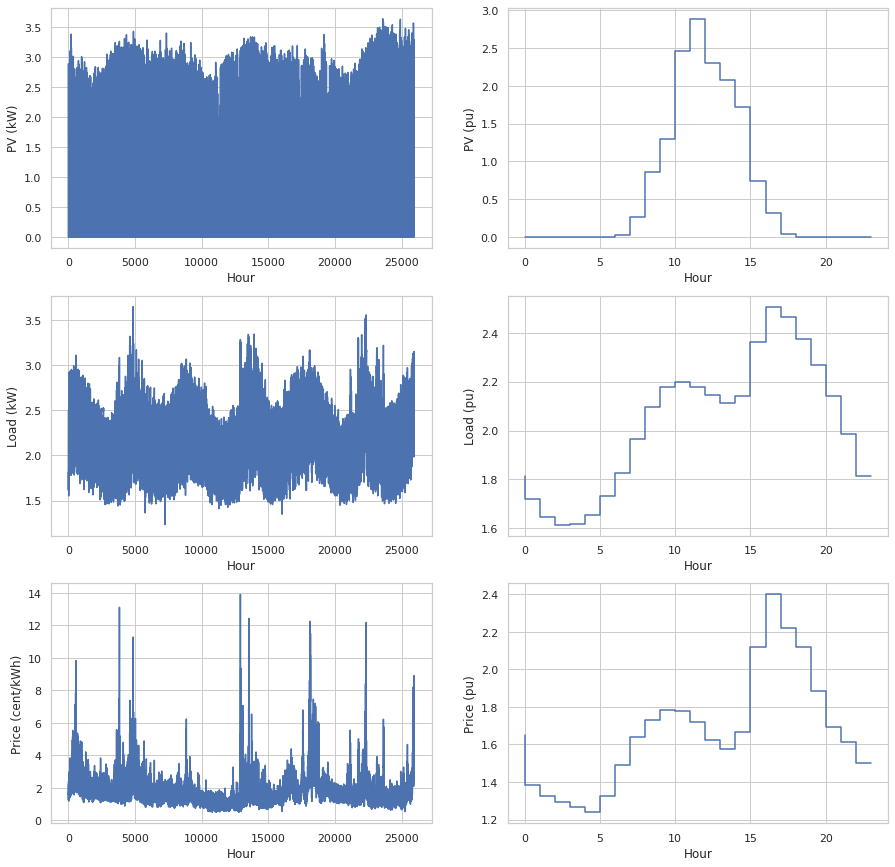

In [7]:
if __name__ == "__main__":
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style="whitegrid")
    
    preprocess_tool = preprocess()
    df = pd.read_csv("Final Modified Data_Rev2.csv")
    df = preprocess_tool.feature_engineering(df)
    x = preprocess_tool.normalize_pv_load_price(df)
    
    """
    df = pd.read_csv("Final Modified Data_Rev2.csv")
    df = df.iloc[:1000, :]
    df = preprocess_tool.feature_engineering(df)
    df.shape, df.columns
    """
    
    fig, ax = plt.subplots(3, 2, figsize = (15, 15))
    ax[0, 0].step(np.arange(len(x[:,0])), x[:,0])
    ax[0, 0].set_xlabel("Hour")
    ax[0, 0].set_ylabel("PV (kW)")
    ax[0, 1].step(np.arange(len(x[0:24,0])), x[0:24,0])
    ax[0, 1].set_xlabel("Hour")
    ax[0, 1].set_ylabel("PV (pu)")
    ax[1, 0].step(np.arange(len(x[:,1])), x[:,1])
    ax[1, 0].set_xlabel("Hour")
    ax[1, 0].set_ylabel("Load (kW)")
    ax[1, 1].step(np.arange(len(x[0:24,1])), x[0:24,1])
    ax[1, 1].set_xlabel("Hour")
    ax[1, 1].set_ylabel("Load (pu)")
    ax[2, 0].step(np.arange(len(x[:,2])), x[:,2])
    ax[2, 0].set_xlabel("Hour")
    ax[2, 0].set_ylabel("Price (cent/kWh)")
    ax[2, 1].step(np.arange(len(x[0:24,2])), x[0:24,2])
    ax[2, 1].set_xlabel("Hour")
    ax[2, 1].set_ylabel("Price (pu)")
    plt.show()